In [ ]:
%%capture
!pip install --upgrade seaborn
!pip install -qq transformers datasets
!pip install pyarrow==11.0.0

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from transformers import AutoTokenizer, AutoModel, AutoModelForSequenceClassification, AdamW, get_scheduler
import torch
from datasets import load_dataset, load_metric
from tqdm.auto import tqdm
from tqdm.notebook import tqdm

# Data Describtion

**Clothing ID**: Integer Categorical variable that refers to the specific piece being reviewed.<p>
**Age**: Positive Integer variable of the reviewers age.<p>
**Title**: String variable for the title of the review.<p>
**Review Text**: String variable for the review body.<p>
**Rating**: Positive Ordinal Integer variable for the product score granted by the customer from 1 Worst, to 5 Best.<p>
**Recommended IND**: Binary variable stating where the customer recommends the product where 1 is recommended, 0 is not recommended.<p>
**Positive Feedback Count**: Positive Integer documenting the number of other customers who found this review positive.<p>
**Division Name**: Categorical name of the product high level division.<p>
**Department Name**: Categorical name of the product department name.<p>
**Class Name**: Categorical name of the product class name.<p>

In [ ]:
train_data = pd.read_csv('/kaggle/input/womens-ecommerce-clothing-reviews/Womens Clothing E-Commerce Reviews.csv')
train_data.sample(5)

,Unnamed: 0,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
14880,14880,445,33,Cartagena cover-up,I love this cover-up. it does feel big when yo...,4,1,3,Initmates,Intimate,Swim
15291,15291,1078,53,NaN,This dress is good quality but the designers t...,4,0,0,General,Dresses,Dresses
10998,10998,1008,33,"Elegant, modern, and fun!",I ordered this beautiful sweater skirt in peti...,5,1,2,General,Bottoms,Skirts
1811,1811,994,35,"Feminine, romantic skirt",This skirt caught my eye immediately. i love t...,5,1,2,General Petite,Bottoms,Skirts
9048,9048,1035,54,NaN,I tried on these jeans in the store because th...,4,1,1,General Petite,Bottoms,Jeans


In [ ]:
train_data.drop('Unnamed: 0', inplace=True, axis=1)

In [ ]:
train_data.nunique()

Clothing ID                 1206
Age                           77
Title                      13993
Review Text                22634
Rating                         5
Recommended IND                2
Positive Feedback Count       82
Division Name                  3
Department Name                6
Class Name                    20
dtype: int64

# EDA

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23486 entries, 0 to 23485
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Clothing ID              23486 non-null  int64 
 1   Age                      23486 non-null  int64 
 2   Title                    19676 non-null  object
 3   Review Text              22641 non-null  object
 4   Rating                   23486 non-null  int64 
 5   Recommended IND          23486 non-null  int64 
 6   Positive Feedback Count  23486 non-null  int64 
 7   Division Name            23472 non-null  object
 8   Department Name          23472 non-null  object
 9   Class Name               23472 non-null  object
dtypes: int64(5), object(5)
memory usage: 1.8+ MB


**Посмотрим на целевую переменную:**

Recommended IND
1    0.822362
0    0.177638
Name: proportion, dtype: float64


<Axes: xlabel='Recommended IND', ylabel='count'>

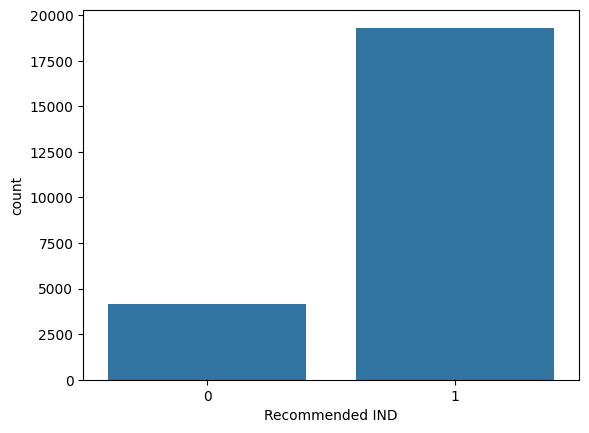

In [ ]:
print(train_data['Recommended IND'].value_counts(normalize=True))
sns.countplot(train_data, x=train_data['Recommended IND'])

**Данные сильно не сбаналнсированы**

In [ ]:
train_data.isna().sum()

Clothing ID                   0
Age                           0
Title                      3810
Review Text                 845
Rating                        0
Recommended IND               0
Positive Feedback Count       0
Division Name                14
Department Name              14
Class Name                   14
dtype: int64

In [ ]:
train_data = train_data.dropna()

In [ ]:
train_data.describe()

,Clothing ID,Age,Rating,Recommended IND,Positive Feedback Count
count,19662.000000,19662.000000,19662.000000,19662.000000,19662.000000
mean,921.297274,43.260808,4.183145,0.818177,2.652477
std,200.227528,12.258122,1.112224,0.385708,5.834285
min,1.000000,18.000000,1.000000,0.000000,0.000000
25%,861.000000,34.000000,4.000000,1.000000,0.000000
50%,936.000000,41.000000,5.000000,1.000000,1.000000
75%,1078.000000,52.000000,5.000000,1.000000,3.000000
max,1205.000000,99.000000,5.000000,1.000000,122.000000


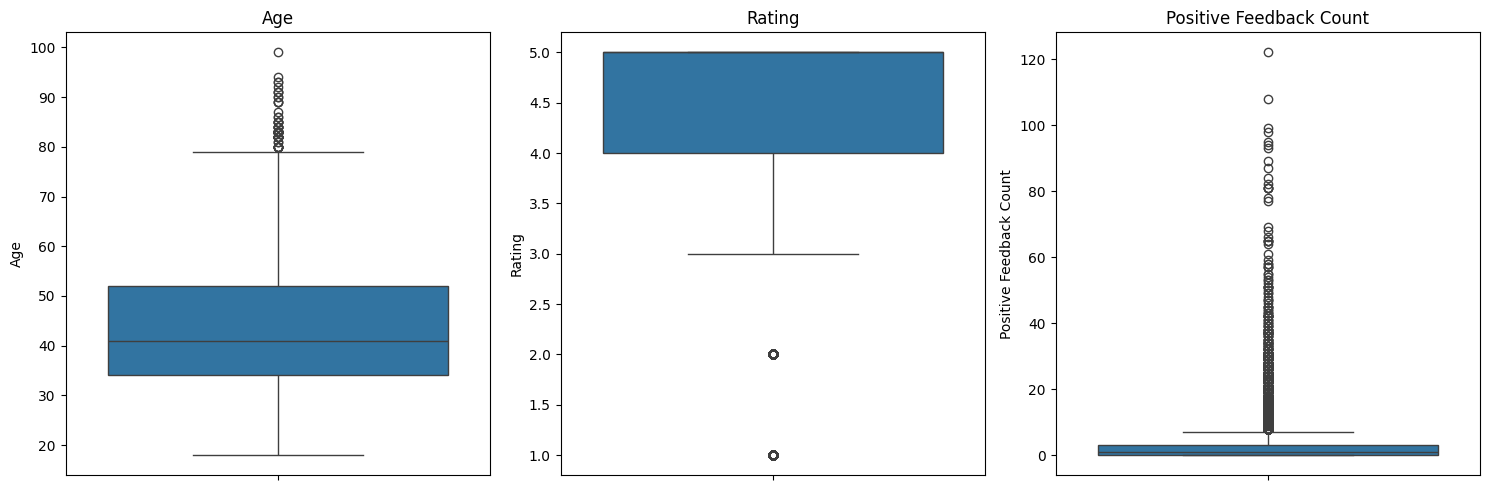

In [ ]:
num_columns = ['Age', 'Rating', 'Positive Feedback Count']

fig, axes = plt.subplots(nrows=1, ncols=len(num_columns), figsize=(15, 5))

for i, col in enumerate(num_columns):
    sns.boxplot(y=train_data[col], ax=axes[i])
    axes[i].set_title(col)
plt.tight_layout()
plt.show()

In [ ]:
train_data[train_data['Positive Feedback Count'] > 3].groupby('Recommended IND').count()

,Clothing ID,Age,Title,Review Text,Rating,Positive Feedback Count,Division Name,Department Name,Class Name
Recommended IND,,,,,,,,,
0,962,962,962,962,962,962,962,962,962
1,3087,3087,3087,3087,3087,3087,3087,3087,3087


**Видим, что пользователи, написавшие отзывы, которые получили большое количество положительных оценок в большей мере с рекомендацией товара, такая тенденция отслеживается и при увеличении границы (здесь - 3)**

Посмотрим на вещи с плохим рейтингом:

In [ ]:
train_data[train_data['Rating'] <= 2].groupby(['Rating', 'Recommended IND'], as_index=False) \
                                     .agg({'Recommended IND': 'count'})

,Rating,Recommended IND
0,1,684
1,1,7
2,2,1280
3,2,80


In [ ]:
train_data[(train_data['Rating'] == 2) & (train_data['Recommended IND'] == 1)]

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
503,948,40,Itchytown,"Is not a place i want to be, even if the style...",2,1,0,General Petite,Tops,Sweaters
829,895,30,Sent to me damaged,I ordered the in the emerald green and it was ...,2,1,0,General,Tops,Fine gauge
1027,1047,34,Not for every body type,"I am 5'6"", 130 lbs with an athletic body type ...",2,1,0,General,Bottoms,Pants
1063,949,44,"I wanted to love this sweater, but......",This is a beautiful sweater with deep rich col...,2,1,1,General,Tops,Sweaters
1316,836,35,I wanted to love it...,I really like the look of the top when it is p...,2,1,8,General,Tops,Blouses
...,...,...,...,...,...,...,...,...,...,...
22824,1020,57,Looooong.,"1. i'm 5'6"" tall with a short waist and long l...",2,1,8,General Petite,Bottoms,Skirts
22989,1008,34,"Everyday skirt, but just okay",The reason for the title above is this skirt d...,2,1,13,General Petite,Bottoms,Skirts
23282,1028,59,Sizing off,"So after reading the 2 reviews, decided to jus...",2,1,0,General Petite,Bottoms,Jeans
23320,640,40,Beautiful dress but it runs very large,I love the look of this dress but it runs very...,2,1,0,General Petite,Intimate,Lounge


Просмотрев данные вручную можно заметить, что есть отзывы, скорее, негативные, но рекомендация остается <p>
**Но так как задача состоит не в определении тональности, оставим все как есть**

Посмторим на то, влияет ли возраст покупателя на рекомендацию

In [ ]:
train_data.groupby(['Age', 'Recommended IND']).agg({'Recommended IND': 'count'})

Recommended IND
Age Recommended IND                 
18  1                              4
19  0                              5
    1                             23
20  0                             13
    1                             78
...                              ...
91  0                              3
92  1                              1
93  1                              2
94  1                              1
99  1                              1

[143 rows x 1 columns]

<Axes: >

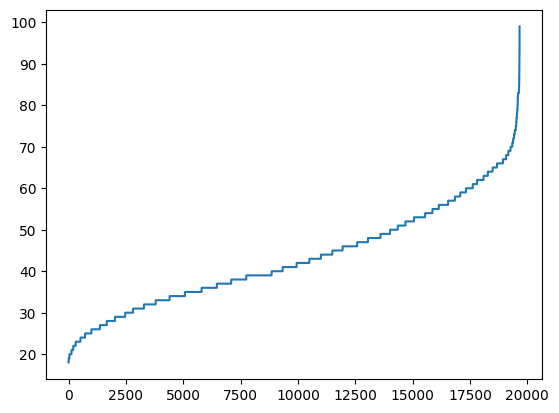

In [ ]:
pd.Series(sorted(train_data['Age'])).plot()

## Text processing

In [ ]:
text_columns = ['Review Text',
                'Recommended IND'
                ]

In [ ]:
text_data = train_data[text_columns].copy()
text_data.head()

,Review Text,Recommended IND
2,I had such high hopes for this dress and reall...,0
3,"I love, love, love this jumpsuit. it's fun, fl...",1
4,This shirt is very flattering to all due to th...,1
5,"I love tracy reese dresses, but this one is no...",0
6,I aded this in my basket at hte last mintue to...,1


In [ ]:
nltk.download("stopwords")
nltk.download('punkt')
eng_stopwords = stopwords.words("english")

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'@\w+|#[\w-]+|http\S+|\n', '', text)
    text = re.sub(r'[^\w\s]', ' ', text)
    words = word_tokenize(text, language='english')
    words = [word for word in words if not re.match(r'^_+$', word)]

    # Исключение стоп-слов можно сделать опциональным т.к. иногда искажает смысл

    return ' '.join(words)

# Посмотрим на обработанные тексты
for i in np.random.randint(0, len(train_data)):
    print('Ориг:', train_data['Review Text'][i])
    print('Чист:', preprocess_text(train_data['Review Text'][i]), '\n')

In [ ]:
text_data['Review Text'] = text_data['Review Text'].apply(preprocess_text)
text_data.rename(columns={'Review Text': 'text', 'Recommended IND': 'labels'}, inplace=True)
text_data.head()

,text,labels
2,i had such high hopes for this dress and reall...,0
3,i love love love this jumpsuit it s fun flirty...,1
4,this shirt is very flattering to all due to th...,1
5,i love tracy reese dresses but this one is not...,0
6,i aded this in my basket at hte last mintue to...,1


In [ ]:
# сохраним обработанные тексты
text_data.to_csv('text_data.csv', index=False)

# Training

In [ ]:
text_data['text'].apply(len).median()

306.0

In [ ]:
model_name = "google-bert/bert-base-cased"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

In [ ]:
full_dataset = load_dataset('csv', data_files='/kaggle/working/text_data.csv')
# full_dataset = full_dataset.filter(lambda example: example['text'] is not None and example['labels'] is not None)

dataset = full_dataset['train'].train_test_split(test_size=0.3)
dataset

Generating train split: 0 examples [00:00, ? examples/s]

Filter:   0%|          | 0/19662 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 13763
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 5899
    })
})

In [ ]:
dataset = dataset.map(lambda e:
                      tokenizer(e['text'],
                                truncation = True,
                                max_length=306,
                                padding='max_length'), batched=True)

dataset = dataset.remove_columns('text')
dataset.set_format(type='torch', device='cuda')

In [ ]:
import torch
from torch.utils.data import DataLoader

# создаем загрузчики данных
train_dataloader = DataLoader(dataset['train'], shuffle=True, batch_size=16)
test_dataloader = DataLoader(dataset['test'], shuffle=False, batch_size=8)

In [ ]:
from transformers import AdamW, get_scheduler

# оптимизатор AdamW, лр стоит поперебирать
optimizer = AdamW(model.parameters(), lr=1e-4)
num_epochs = 3
# количество шагов
num_training_steps = num_epochs * len(train_dataloader)

In [ ]:
lr_scheduler = get_scheduler(
    "cosine",
    optimizer=optimizer,
    num_warmup_steps= int(0.1 * num_epochs * len(train_dataloader)),
    num_training_steps=num_training_steps
)

In [ ]:
best_f1 = 0.
running_loss = []

for epoch in range(num_epochs):
    print(40*'-', f'\nEpoch {epoch+1}')

    # Переводим модель в режим обучения
    model.train()
    pbar = tqdm(train_dataloader, total=len(train_dataloader), desc='Training')

    for i, batch in enumerate(pbar):

        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss

        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        running_loss.append(loss.item())
        pbar.set_postfix({'running_loss': np.mean(running_loss[-25:])})

    # Валидация модели
    print('\nValidating...')
    model.eval()

    f1 = load_metric('f1', trust_remote_code=True)
    acc = load_metric('accuracy', trust_remote_code=True)
    precision = load_metric('precision', trust_remote_code=True)
    recall = load_metric('recall', trust_remote_code=True)

    val_loss = []

    pbar = tqdm(test_dataloader, total=len(test_dataloader), desc='Validation')

    for batch in tqdm(pbar):
        batch = {k: v.to(device) for k, v in batch.items()}

        with torch.no_grad():
            outputs = model(**batch)

        logits = outputs.logits.detach().cpu()
        predictions = torch.argmax(logits, dim=-1)

        f1.add_batch(predictions=predictions, references=batch["labels"].detach().cpu())
        acc.add_batch(predictions=predictions, references=batch["labels"].detach().cpu())
        precision.add_batch(predictions=predictions, references=batch["labels"].detach().cpu())
        recall.add_batch(predictions=predictions, references=batch["labels"].detach().cpu())

        val_loss.append(outputs.loss.item())
        pbar.set_postfix({'val_loss': np.mean(val_loss[-25:])})

    # Выводим итоги по метрикам
    print('Weighted Summary:')
    test_acc = acc.compute()['accuracy']
    test_precision = precision.compute(average='weighted')['precision']
    test_recall = recall.compute(average='weighted')['recall']
    f1_weighted = f1.compute(average='weighted')['f1']
    print(f'[{epoch+1}] Test Accuracy: {test_acc:.4f}')
    print(f'[{epoch+1}] Test Precision: {test_precision:.4f}')
    print(f'[{epoch+1}] Test Recall: {test_recall:.4f}')
    print(f'[{epoch+1}] Test F1: {f1_weighted:.4f}')

    # Сохраняем модель при улучшении F1
    if f1_weighted > best_f1:
        best_f1 = f1_weighted
        model.save_pretrained(f"best_model_nov_f1_max={best_f1}_len=100")
        print(f"New best F1: {best_f1}. Model saved.")